In [1]:
%load_ext watermark

import arviz as az
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import pymc3 as pm
import theano.tensor as tt
import warnings

from scipy.special import expit as logistic
from scipy.special import softmax

warnings.simplefilter(action="ignore", category=FutureWarning)
RANDOM_SEED = 8927
np.random.seed(286)

PARTIES = ["farleft", "left", "green", "center", "right", "farright", "other"]
PARTIES_AGG = [
    "farleft_agg",
    "left_agg",
    "green_agg",
    "center_agg",
    "right_agg",
    "farright_agg",
]
SPAN_ELECTIONS = 20
ALPHA_ELECTIONS = 2 / (SPAN_ELECTIONS + 1)
SPAN_POLLS = 5
ALPHA_POLLS = 2 / (SPAN_POLLS + 1)

In [2]:
import bokeh.plotting as bkp

from bokeh.io import output_notebook, show
from bokeh.layouts import column, gridplot
from bokeh.models import ColorBar, GeoJSONDataSource, HoverTool, LinearColorMapper
from bokeh.models.annotations import Title
from bokeh.models.widgets import Select
from bokeh.palettes import brewer
from bokeh.transform import linear_cmap

output_notebook()
BINS = np.array([15., 25., 35., 45., 55., 65., 75.])
COLORS = {
    "farleft": np.array(brewer["Reds"][7][::-1]),
    "left": np.array(brewer["PuRd"][7][::-1]),
    "green": np.array(brewer["Greens"][7][::-1]),
    "center": np.array(brewer["Oranges"][7][::-1]),
    "right": np.array(brewer["Blues"][7][::-1]),
    "farright": np.array(brewer["Purples"][7][::-1]),
    "other": np.array(brewer["Greys"][7][::-1]),
}

Loading BokehJS ...

In [3]:
az.style.use("arviz-darkgrid")


def stdz(series: pd.Series) -> pd.Series:
    """Standardize the given pandas Series"""
    return (series - series.mean()) / series.std()


def get_top_n(df: pd.DataFrame, nlargest: int = 3) -> pd.DataFrame:

    order = np.argsort(-df.values, axis=1)[:, :nlargest]
    # the "-" is a common trick to argsort in decreasing order

    return pd.DataFrame(
        df.columns[order].values,
        columns=[f"top{i}" for i in range(1, nlargest + 1)],
        index=df.index,
    )

Let's load the data and transform every missing values to 0: except for the "other" category, when a party is missing, this means that it got 0 votes, so it makes sense to replace NaNs by 0s. Note however that these zeros do not come from the multinomial process - unlike the zeros in the "other" category, but from an earlier process that determines if any given party competes in the election. We'll deal with that below, but let's already remark that this looks a lot like a zero-inflated process...

In [4]:
d = pd.read_excel("../data/results_by_districts_paris.xlsx", index_col=0)
# a party that wasn't there won 0 ballots:
d[PARTIES] = d[PARTIES].fillna(0).astype(int)

euro2019 = pd.read_excel("../data/raw_election_results_1st_round/euro2019-districts.xlsx").rename(columns={"district": "arrondissement"})
euro2019["date"] = pd.to_datetime("2019-05-25")
euro2019["ville"] = "Paris"
euro2019["type"] = "european"

d = pd.concat([d, euro2019], axis=0, sort=False).sort_values(["arrondissement", "date"]).reset_index(drop=True)

In [5]:
# keep track of which party was the incumbent for each election:
INCUMBENTS = {
    date: incumbent
    for date, incumbent in zip(
        d.date.unique(),
        [
            "right",
            "right",
            "left",
            "left",
            "left",
            "right",
            "right",
            "left",
            "right",
            "left",
            "left",
            "left",
            "farright"
        ],
    )
}
for date, incumbent in INCUMBENTS.items():
    d.loc[d.date == date, "incumbent"] = incumbent
right_inc = (d.incumbent == "right").astype(int).values
left_inc = (d.incumbent == "left").astype(int).values
d

date  ville  arrondissement      N  farleft   left  green  center  \
0   2007-04-22  Paris               1   9152      239   2530    205    2051   
1   2007-06-10  Paris               1   6825      243      0   1969     818   
2   2008-03-09  Paris               1   6127       75   2289    439     531   
3   2009-06-07  Paris               1   5212      275    665   1493     419   
4   2010-03-14  Paris               1   4843      295   1077   1038     177   
..         ...    ...             ...    ...      ...    ...    ...     ...   
255 2014-05-25  Paris              20  49075     4974  10575   9498    4218   
256 2015-12-06  Paris              20  49130     6100  18315   7348       0   
257 2017-04-23  Paris              20  89574    28512  12469      0   27399   
258 2017-06-11  Paris              20  57413    11546  10700   7766    6505   
259 2019-05-25  Paris              20  59313     5493   6187  14684   12721   

     right  farright  other         type incumbent  
0     3595       418    114    president     right  
1     3430       158    207  legislative     right  
2     2641       152      0   municipale      left  
3     1808       127    425     european      left  
4     1758       261    237     regional      left  
..     ...       ...    ...          ...       ...  
255   5994      4584   9232     european     right  
256   8340      4977   4050     regional      left  
257  11451      5305   4438    president      left  
258   4300      2446  14150  legislative      left  
259   2556      4430  13242     european  farright  

[260 rows x 13 columns]

In [7]:
TIMELINE = sorted(np.arange(np.min(d.date.dt.year.unique()), 2021), reverse=True)
year_weights = pd.DataFrame(
    index=TIMELINE,
    data=[(1 - ALPHA_ELECTIONS) ** i for i, _ in enumerate(TIMELINE)],
    columns=["year_weights"],
)

# add year_weights to results dataframe:
d.index = d.date.dt.year
d.index.name = "year"
d = d.join(year_weights).sort_values(["arrondissement", "date"]).reset_index(drop=True)

d["N"] = d[PARTIES].multiply(d.year_weights, axis="index").round().sum(1).astype(int)
d[PARTIES] = d[PARTIES].multiply(d.year_weights, axis="index").round().astype(int)
d

date  ville  arrondissement      N  farleft   left  green  center  \
0   2007-04-22  Paris               1   2492       65    689     56     558   
1   2007-06-10  Paris               1   1858       66      0    536     223   
2   2008-03-09  Paris               1   1845       23    689    132     160   
3   2009-06-07  Paris               1   1732       91    221    497     139   
4   2010-03-14  Paris               1   1780      108    396    382      65   
..         ...    ...             ...    ...      ...    ...    ...     ...   
255 2014-05-25  Paris              20  26919     2728   5801   5210    2314   
256 2015-12-06  Paris              20  29785     3698  11104   4455       0   
257 2017-04-23  Paris              20  66342    21117   9235      0   20293   
258 2017-06-11  Paris              20  42523     8551   7925   5752    4818   
259 2019-05-25  Paris              20  53665     4970   5598  13286   11509   

     right  farright  other         type incumbent  year_weights  
0      979       114     31    president     right      0.272236  
1      934        43     56  legislative     right      0.272236  
2      795        46      0   municipale      left      0.300893  
3      601        42    141     european      left      0.332566  
4      646        96     87     regional      left      0.367573  
..     ...       ...    ...          ...       ...           ...  
255   3288      2514   5064     european     right      0.548537  
256   5056      3017   2455     regional      left      0.606278  
257   8481      3929   3287    president      left      0.740633  
258   3185      1812  10480  legislative      left      0.740633  
259   2313      4008  11981     european  farright      0.904762  

[260 rows x 14 columns]

In [8]:
district_id, districts = d.arrondissement.factorize(sort=True)
Ndistricts = len(districts)

type_id, types = d.type.factorize(sort=True)
Ntypes = len(types)

Nparties = len(PARTIES) - 1
N = d.N.values
R_obs = d[PARTIES].values

# which parties are available for choice
# huge value for missing parties, so that probability is 0 after softmax:
parties_available = (
    d[PARTIES]
    .astype(bool)
    .astype(int)
    .iloc[:, :-1]
    .replace(to_replace=0, value=50_000)
    .values
)
parties_available

array([[    1,     1,     1,     1,     1,     1],
       [    1, 50000,     1,     1,     1,     1],
       [    1,     1,     1,     1,     1,     1],
       ...,
       [    1,     1, 50000,     1,     1,     1],
       [    1,     1,     1,     1,     1,     1],
       [    1,     1,     1,     1,     1,     1]])

Then we add a predictor to the dataset, which is the unemployment rate in Paris on a quarterly basis:

In [9]:
unemp = pd.read_excel(
    "../data/predictors/chomage-zone-demploi-2003-2019.xls",
    header=5,
    sheet_name="txcho_ze",
)
unemp = unemp[unemp["LIBZE2010"] == "Paris"].iloc[:, 4:].T
unemp.columns = ["unemployment"]

# as timestamps variables:
unemp.index = pd.PeriodIndex(start=unemp.index[0], periods=len(unemp), freq="Q")
unemp

unemployment
2003Q1           8.4
2003Q2           8.7
2003Q3           8.6
2003Q4           9.0
2004Q1           9.2
...              ...
2018Q3           7.7
2018Q4           7.4
2019Q1           7.4
2019Q2           7.2
2019Q3           7.4

[67 rows x 1 columns]

Now ne need to import the poll aggregation for each election. This will be our baseline for each party in each district:

In [10]:
polls1 = pd.read_excel(
    "../data/polls_1st_round/aggregated_polls.xlsx", index_col=0
)
polls2 = pd.read_excel(
    "../data/polls_1st_round/agg_polls_euro2019.xlsx"
).iloc[-1].drop(["souv", "other"])
polls2.index = polls1.columns[1:]
polls2["type"] = "europeennes"

aggregated_polls = polls1.append(polls2, ignore_index=True)
aggregated_polls[PARTIES_AGG] = aggregated_polls[PARTIES_AGG].div(100)
aggregated_polls.round(2)

type dateelection  samplesize_agg  farleft_agg  left_agg  \
0      president   2007-04-22            1513         0.03      0.24   
1   legislatives   2007-06-10             916         0.07      0.28   
2     municipale   2008-03-09             755         0.04      0.45   
3    europeennes   2009-06-07            2287         0.13      0.20   
4     regionales   2010-03-14             907         0.10      0.29   
5      president   2012-04-22            1400         0.14      0.28   
6   legislatives   2012-06-10            1193         0.08      0.32   
7     municipale   2014-03-23             977         0.06      0.38   
8    europeennes   2014-05-25            3248         0.08      0.17   
9     regionales   2015-12-06            1749         0.05      0.23   
10     president   2017-04-23            1555         0.19      0.08   
11  legislatives   2017-06-11            1299         0.12      0.08   
12   europeennes   2019-05-25            2221         0.08      0.05   

    green_agg  center_agg  right_agg  farright_agg  
0        0.01        0.19       0.27          0.14  
1        0.04        0.11       0.41          0.06  
2        0.06        0.08       0.33          0.02  
3        0.13        0.11       0.27          0.06  
4        0.14        0.05       0.29          0.09  
5        0.03        0.10       0.27          0.16  
6        0.05        0.03       0.34          0.15  
7        0.07        0.00       0.37          0.08  
8        0.09        0.10       0.21          0.23  
9        0.06        0.00       0.28          0.29  
10       0.00        0.24       0.19          0.22  
11       0.03        0.30       0.21          0.17  
12       0.08        0.23       0.14          0.25

As you probably noticed, the polls are in shares of support. Since our link function is softmax, we need to convert these proportions back on the real line (because the polls will be used before the link function appears in our model). It's [really easy to invert the softmax](https://math.stackexchange.com/questions/2786600/invert-the-softmax-function): we just have to take the log of each proportion and add an arbitrary constant -- here, we chose 1.

But hold on! There are two zeros in these data (for center party during the 2014 city-council and 2015 regional elections). It's due to the fact that this party was not running during these elections. When we'll take the logarithm of these zeros, we'll get minus infinity -- spoiler alert: our sampler won't like that. So we'll have to use a trick here.

Notice that the green party has a very low share of polls in the 2017 presidential elections. It's because there were some polls featuring the green party at the beginning of the race, but not anymore once the party dropped out. This is useful for us here: as a results, the poll aggregation is very near zero but not _exactly_ zero, so on the log scale it will give a very negative number but not minus infinity.

So here is our trick: let's replace the zeros for the center party by the value for the green party during the 2017 presidential election. This might seem like a cheap trick but it actually makes some conceptual sense: our model is concerned with the _latent_ support of each party's in the population. And in reality, neither the center nor the green parties were at _exactly_ zero percent support during these years -- they just had a very low support, which actually forced them to drop out and make alliances. So, replacing our perfect zeros with not-so-perfect zeros does make sense!

Here is how it looks in code:

In [11]:
aggregated_polls[PARTIES_AGG] = aggregated_polls[PARTIES_AGG].replace(
    to_replace=0,
    value=aggregated_polls.loc[
        aggregated_polls.dateelection == "2017-04-23", "green_agg"
    ].values[0],
)

# revert the softmax:
aggregated_polls[PARTIES_AGG] = aggregated_polls[PARTIES_AGG].apply(np.log) + 1
aggregated_polls.round(2)

type dateelection  samplesize_agg  farleft_agg  left_agg  \
0      president   2007-04-22            1513        -2.63     -0.43   
1   legislatives   2007-06-10             916        -1.61     -0.29   
2     municipale   2008-03-09             755        -2.33      0.19   
3    europeennes   2009-06-07            2287        -1.04     -0.63   
4     regionales   2010-03-14             907        -1.32     -0.24   
5      president   2012-04-22            1400        -0.99     -0.29   
6   legislatives   2012-06-10            1193        -1.53     -0.14   
7     municipale   2014-03-23             977        -1.88      0.04   
8    europeennes   2014-05-25            3248        -1.58     -0.79   
9     regionales   2015-12-06            1749        -1.94     -0.47   
10     president   2017-04-23            1555        -0.67     -1.57   
11  legislatives   2017-06-11            1299        -1.14     -1.53   
12   europeennes   2019-05-25            2221        -1.48     -1.98   

    green_agg  center_agg  right_agg  farright_agg  
0       -3.95       -0.67      -0.30         -0.95  
1       -2.30       -1.20       0.12         -1.76  
2       -1.85       -1.51      -0.12         -2.82  
3       -1.01       -1.19      -0.30         -1.85  
4       -1.00       -2.06      -0.24         -1.40  
5       -2.68       -1.27      -0.32         -0.84  
6       -1.98       -2.58      -0.09         -0.88  
7       -1.73      -22.24      -0.01         -1.50  
8       -1.42       -1.33      -0.54         -0.46  
9       -1.84      -22.24      -0.27         -0.24  
10     -22.24       -0.44      -0.64         -0.49  
11      -2.51       -0.19      -0.56         -0.75  
12      -1.49       -0.48      -0.95         -0.40

And now we combine all district- and city-level predictors as well as polls and election results into the same dataframe:

In [12]:
# add quarters to results dataframe:
d.index = pd.DatetimeIndex(d["date"].values).to_period("Q")
d.index.name = "quarter"
# merge with city-level unemployment:
d = d.join(unemp).sort_values(["arrondissement", "date"]).reset_index(drop=True)

# join polling aggregation:
d = d.merge(
    aggregated_polls.drop("type", 1),
    left_on="date",
    right_on="dateelection",
    how="left",
).drop("dateelection", 1)
d

date  ville  arrondissement      N  farleft   left  green  center  \
0   2007-04-22  Paris               1   2492       65    689     56     558   
1   2007-06-10  Paris               1   1858       66      0    536     223   
2   2008-03-09  Paris               1   1845       23    689    132     160   
3   2009-06-07  Paris               1   1732       91    221    497     139   
4   2010-03-14  Paris               1   1780      108    396    382      65   
..         ...    ...             ...    ...      ...    ...    ...     ...   
255 2014-05-25  Paris              20  26919     2728   5801   5210    2314   
256 2015-12-06  Paris              20  29785     3698  11104   4455       0   
257 2017-04-23  Paris              20  66342    21117   9235      0   20293   
258 2017-06-11  Paris              20  42523     8551   7925   5752    4818   
259 2019-05-25  Paris              20  53665     4970   5598  13286   11509   

     right  farright  ...  incumbent year_weights unemployment  \
0      979       114  ...      right     0.272236          7.8   
1      934        43  ...      right     0.272236          7.8   
2      795        46  ...       left     0.300893          6.6   
3      601        42  ...       left     0.332566          7.9   
4      646        96  ...       left     0.367573          8.2   
..     ...       ...  ...        ...          ...          ...   
255   3288      2514  ...      right     0.548537          8.8   
256   5056      3017  ...       left     0.606278          8.7   
257   8481      3929  ...       left     0.740633          8.0   
258   3185      1812  ...       left     0.740633          8.0   
259   2313      4008  ...   farright     0.904762          7.2   

     samplesize_agg  farleft_agg  left_agg  green_agg  center_agg  right_agg  \
0              1513    -2.633513 -0.432471  -3.950292   -0.670963  -0.296018   
1               916    -1.613136 -0.288538  -2.295177   -1.196553   0.116238   
2               755    -2.327655  0.190572  -1.849138   -1.513482  -0.116553   
3              2287    -1.040641 -0.628886  -1.013539   -1.192074  -0.299655   
4               907    -1.319981 -0.240301  -0.996263   -2.061018  -0.240266   
..              ...          ...       ...        ...         ...        ...   
255            3248    -1.582788 -0.790411  -1.420928   -1.334419  -0.537229   
256            1749    -1.943570 -0.473766  -1.836909  -22.243938  -0.268955   
257            1555    -0.667318 -1.565596 -22.243938   -0.437694  -0.640817   
258            1299    -1.144984 -1.528224  -2.510045   -0.191539  -0.560378   
259            2221    -1.477348 -1.976608  -1.490665   -0.482563  -0.945211   

     farright_agg  
0       -0.946153  
1       -1.763649  
2       -2.824834  
3       -1.854871  
4       -1.398709  
..            ...  
255     -0.460404  
256     -0.241968  
257     -0.493163  
258     -0.747776  
259     -0.402676  

[260 rows x 22 columns]

Ok, everything's ready, let's run our model! This a varying-effects model that takes into account not only the variation in slopes and intercepts, but also accounts for the *covariation between slopes and intercepts* -- it exploits additional information about the population in order to shrink in both dimensions.

In [12]:
with pm.Model() as m_dos_effects:
    mus_parties = []
    log_unemployment = stdz(np.log(d.unemployment)).values
    for p_id, p in enumerate(PARTIES_AGG):
        stdz_polls = stdz(d[p]).values

        if p in ["left_agg", "right_agg"]:
            sd_dist = pm.Exponential.dist(1.0)
            packed_chol = pm.LKJCholeskyCov(
                f"pchol_district_p{p_id}", eta=4, n=4, sd_dist=sd_dist
            )

            # compute covariance matrix:
            chol = pm.expand_packed_triangular(n=4, packed=packed_chol, lower=True)
            cov = pm.math.dot(chol, chol.T)

            # extract rho and standard deviations:
            sigma_district = pm.Deterministic(
                f"sigma_district_p{p_id}", tt.sqrt(tt.diag(cov))
            )
            corr = tt.diag(sigma_district ** -1).dot(
                cov.dot(tt.diag(sigma_district ** -1))
            )
            r = pm.Deterministic(
                f"Rho_district_p{p_id}", corr[np.triu_indices(n=4, k=1)]
            )

            # average itc and slopes:
            β = pm.Normal(
                f"β_p{p_id}",
                mu=np.array([-1.4, 0.0, 0.1, 0.0]),
                sd=np.array([0.5, 0.05, 0.05, 0.5]),
                shape=4,
            )

            # population of varying effects:
            β_district = pm.MvNormal(
                f"β_district_p{p_id}", mu=β, chol=chol, shape=(Ndistricts, 4)
            )
            type_effect = pm.Normal(
                f"type_effect_p{p_id}", mu=0.0, sigma=0.05, shape=Ntypes
            )

            if p == "right_agg":
                # linear model:
                mus_parties.append(
                    β_district[district_id, 0]
                    + type_effect[type_id]
                    + β_district[district_id, 1] * log_unemployment
                    + β_district[district_id, 2] * stdz_polls
                    + β_district[district_id, 3] * right_inc
                )
            else:
                mus_parties.append(
                    β_district[district_id, 0]
                    + type_effect[type_id]
                    + β_district[district_id, 1] * log_unemployment
                    + β_district[district_id, 2] * stdz_polls
                    + β_district[district_id, 3] * left_inc
                )

        else:
            sd_dist = pm.Exponential.dist(1.0)
            packed_chol = pm.LKJCholeskyCov(
                f"pchol_district_p{p_id}", eta=4, n=3, sd_dist=sd_dist
            )
            chol = pm.expand_packed_triangular(n=3, packed=packed_chol, lower=True)
            cov = pm.math.dot(chol, chol.T)
            sigma_district = pm.Deterministic(
                f"sigma_district_p{p_id}", tt.sqrt(tt.diag(cov))
            )
            corr = tt.diag(sigma_district ** -1).dot(
                cov.dot(tt.diag(sigma_district ** -1))
            )
            r = pm.Deterministic(
                f"Rho_district_p{p_id}", corr[np.triu_indices(n=3, k=1)]
            )

            if p == "center_agg":
                β = pm.Normal(
                    f"β_p{p_id}",
                    mu=np.array([-1.4, 0.0, 0.1]),
                    sd=np.array([0.5, 0.05, 0.05]),
                    shape=3,
                )
            elif p in ["farleft_agg", "green_agg"]:
                β = pm.Normal(
                    f"β_p{p_id}",
                    mu=np.array([-1.9, 0.0, 0.1]),
                    sd=np.array([0.5, 0.05, 0.05]),
                    shape=3,
                )
            elif p == "farright_agg":
                β = pm.Normal(
                    f"β_p{p_id}",
                    mu=np.array([-2.7, 0.0, 0.0]),
                    sd=np.array([0.5, 0.05, 0.05]),
                    shape=3,
                )
            β_district = pm.MvNormal(
                f"β_district_p{p_id}", mu=β, chol=chol, shape=(Ndistricts, 3)
            )
            type_effect = pm.Normal(
                f"type_effect_p{p_id}", mu=0.0, sigma=0.05, shape=Ntypes
            )
            mus_parties.append(
                β_district[district_id, 0]
                + type_effect[type_id]
                + β_district[district_id, 1] * log_unemployment
                + β_district[district_id, 2] * stdz_polls
            )

    mus_parties = tt.as_tensor_variable(mus_parties).T

    # account for polling errors, media narratives, “October surprises":
    noisy_mus = pm.Normal("noisy_mus", mus_parties, 0.08, shape=mus_parties.tag.test_value.shape)

    # zero-inflation process:
    # push non-available parties towards -inf:
    noisy_mus = parties_available * noisy_mus
    
    # append last category:
    vary_pivot = pm.Normal("vary_pivot", mu=-3.0, sigma=0.05, shape=(len(d), 1))
    noisy_mus = tt.horizontal_stack(noisy_mus, vary_pivot)

    # preferences of each district, for all elections:
    p_district = pm.Deterministic("p_district", tt.nnet.softmax(noisy_mus))

    R = pm.Multinomial("R", n=N, p=p_district, observed=R_obs)
    prior_checks = pm.sample_prior_predictive(random_seed=RANDOM_SEED)

In [14]:
with m_dos_effects:
    trace_dos_effects = pm.sample(
        1000, tune=3000, cores=6, chains=4, random_seed=RANDOM_SEED, init="adapt_diag"
    )

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 6 jobs)
NUTS: [vary_pivot, noisy_mus, type_effect_p5, β_district_p5, β_p5, pchol_district_p5, type_effect_p4, β_district_p4, β_p4, pchol_district_p4, type_effect_p3, β_district_p3, β_p3, pchol_district_p3, type_effect_p2, β_district_p2, β_p2, pchol_district_p2, type_effect_p1, β_district_p1, β_p1, pchol_district_p1, type_effect_p0, β_district_p0, β_p0, pchol_district_p0]
Sampling 4 chains, 0 divergences: 100%|██████████| 16000/16000 [49:56<00:00,  5.34draws/s] 


In [15]:
az.summary(trace_dos_effects, round_to=2)

mean    sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  \
β_p0[0]            -2.74  0.19   -3.08    -2.39        0.0      0.0   4822.65   
β_p0[1]            -0.08  0.03   -0.14    -0.02        0.0      0.0   4452.20   
β_p0[2]             0.33  0.03    0.28     0.38        0.0      0.0   4575.74   
β_district_p0[0,0] -3.14  0.05   -3.23    -3.05        0.0      0.0   3025.22   
β_district_p0[0,1] -0.20  0.04   -0.28    -0.12        0.0      0.0   3822.80   
...                  ...   ...     ...      ...        ...      ...       ...   
p_district[259,2]   0.25  0.00    0.24     0.25        0.0      0.0   4344.11   
p_district[259,3]   0.21  0.00    0.21     0.22        0.0      0.0   3988.78   
p_district[259,4]   0.04  0.00    0.04     0.04        0.0      0.0   4300.44   
p_district[259,5]   0.07  0.00    0.07     0.08        0.0      0.0   3930.74   
p_district[259,6]   0.22  0.00    0.22     0.23        0.0      0.0   4330.93   

                     ess_sd  ess_bulk  ess_tail  r_hat  
β_p0[0]             4822.65   5207.76   3293.36    1.0  
β_p0[1]             4452.20   4534.83   3333.43    1.0  
β_p0[2]             4575.74   5039.09   3208.78    1.0  
β_district_p0[0,0]  3025.22   3008.21   3185.00    1.0  
β_district_p0[0,1]  3783.55   3823.44   3097.13    1.0  
...                     ...       ...       ...    ...  
p_district[259,2]   4339.72   4346.18   2670.20    1.0  
p_district[259,3]   3982.86   3992.81   2940.45    1.0  
p_district[259,4]   4300.44   4295.48   2621.46    1.0  
p_district[259,5]   3929.41   3921.40   2861.45    1.0  
p_district[259,6]   4330.93   4337.70   2847.30    1.0  

[4178 rows x 11 columns]

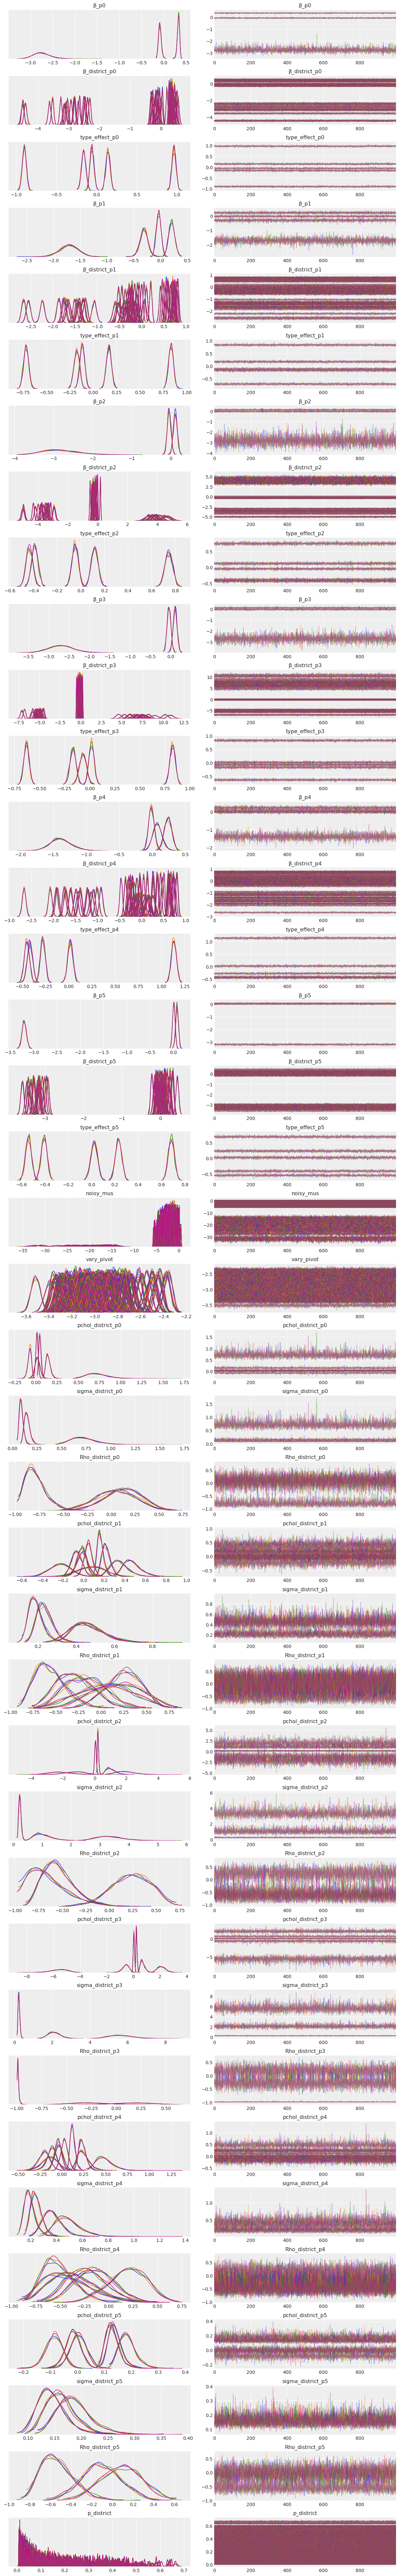

In [16]:
az.plot_trace(trace_dos_effects, compact=True);

In [17]:
share_est = trace_dos_effects["p_district"]
share_mean = share_est.mean(0)

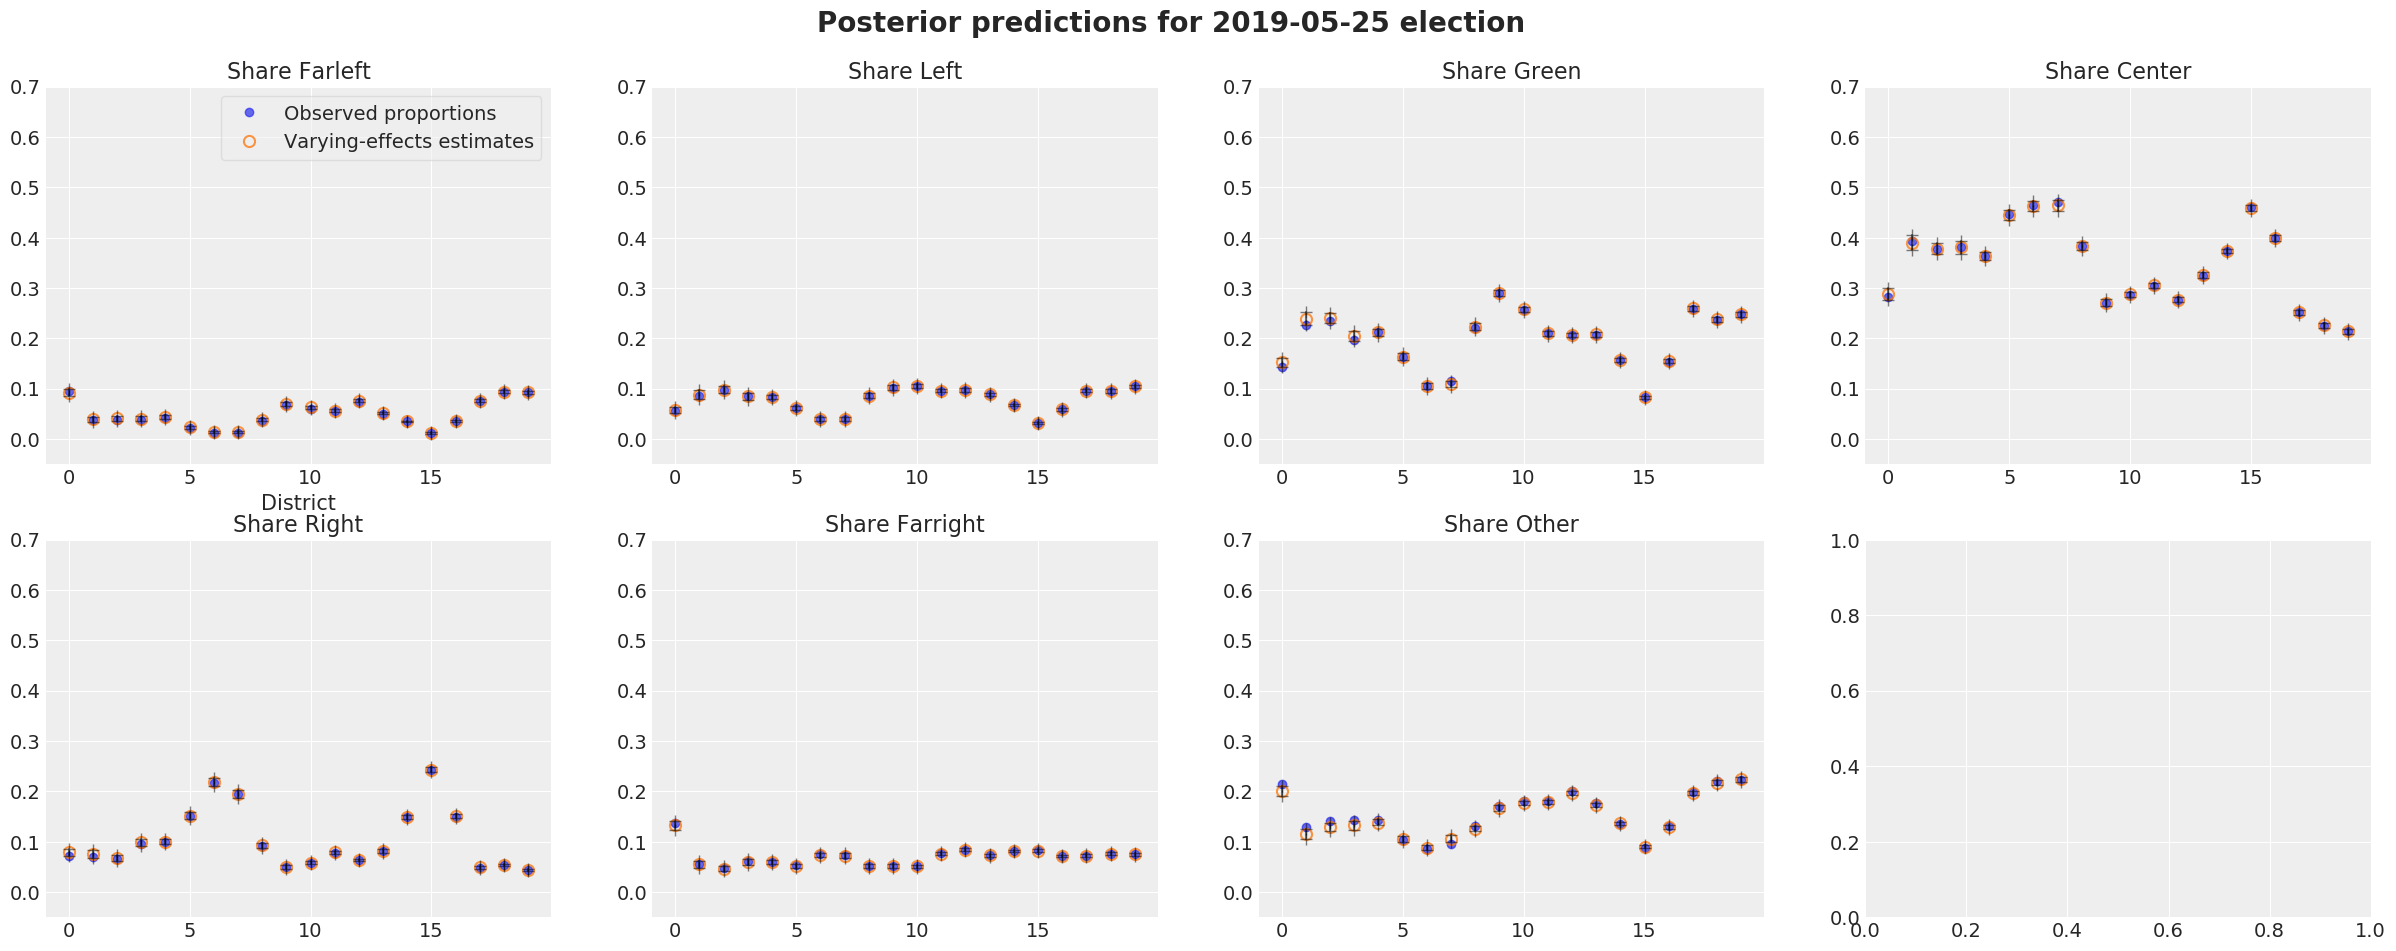

In [37]:
election = np.random.choice(d.date.unique(), replace=False)
election_mask = d.date == election
fig, axes = plt.subplots(2, 4, figsize=(30, 11))
for i, ax in enumerate(axes.flat):
    try:
        ax.plot(
            np.arange(Ndistricts),
            d.loc[election_mask, PARTIES[i]] / d.loc[election_mask, "N"],
            "o",
            ms=6,
            alpha=0.7,
            label="Observed proportions",
        )
        ax.plot(
            np.arange(Ndistricts),
            share_mean[election_mask, i],
            "o",
            fillstyle="none",
            ms=8,
            markeredgewidth=1.5,
            alpha=0.8,
            label="Varying-effects estimates",
        )
        ax.plot(
            [np.arange(Ndistricts), np.arange(Ndistricts)],
            az.hpd(share_est[:, election_mask, i], credible_interval=0.99).T,
            "k-+",
            ms=8,
            alpha=0.5,
        )
        ax.set_xticks(range(Ndistricts), range(1, Ndistricts + 1))
        ax.set_title(f"Share {PARTIES[i].title()}")
        ax.set_ylim([-0.05, 0.7])
        if i == 0:
            ax.set_xlabel("District")
            ax.legend(frameon=True, framealpha=0.5)
    except IndexError:
        continue
fig.suptitle(
    f"Posterior predictions for {np.datetime_as_string(election, unit='D')} election",
    y=0.95,
    size=20,
    weight="bold",
);

In [38]:
with open("trace_prod.pkl", "wb") as f:
    pickle.dump({"model": m_dos_effects, "trace": trace_dos_effects}, f)

In [13]:
with open("trace_prod.pkl", "rb") as f:
    data = pickle.load(f)
m_prod, trace_prod = data["model"], data["trace"]
idata = az.from_pymc3(trace_prod)
post = idata.posterior

#### Scrape 2020 polls for out-of-sample predictions:

In [29]:
CANDIDATES = {"Simonnet": "farleft", "Hidalgo": "left", "Belliard": "green", "Buzyn": "center", "Griveaux": "center", "Dati": "right", "Federbusch": "farright"}
MONTHS = {"janvier": 1, "février": 2, "mars": 3}
RIGHT_POLLSTER = {
    "Harris Interactive": "Harris",
    "Ifop-Fiducial": "Ifop",
    "Ipsos-Sopra Steria": "Ipsos",
}

In [31]:
raw_polls = pd.read_html("https://fr.wikipedia.org/wiki/%C3%89lections_municipales_de_2020_%C3%A0_Paris", 
                         attrs = {'class': 'wikitable centre'}, 
                         match="Date de réalisation",
                         decimal=",",
                         thousands=" ",
                         na_values="—")[0]
raw_polls.columns = raw_polls.columns.droplevel([0, 2])
raw_polls = raw_polls[~raw_polls.Source.str.contains("candidature | annonce | renonce")].drop(["Gantzer", "Villani", "Bournazel", "Campion", "Berkani", "Autres"], axis=1)

# clean polls' characteristics:
raw_polls = raw_polls.rename(columns={"Source": "pollster", "Date de réalisation": "date", "Échantillon": "samplesize"})
raw_polls["pollster"] = raw_polls.pollster.replace(RIGHT_POLLSTER)
raw_polls["samplesize"] = raw_polls["samplesize"].str.split().str.join("").astype(int)

#compute median field date:
field = raw_polls["date"].str.split(expand=True)
field["day"] = field[[0, 2]].median(axis=1).apply(np.ceil).astype(int)
field["month"] = field[3].replace(MONTHS)
field["year"] = 2020
raw_polls["date"] = pd.to_datetime(field[["day", "month", "year"]])

# clean candidates' values:
raw_polls[list(CANDIDATES.keys())] = raw_polls[CANDIDATES.keys()].astype(float)
raw_polls["Buzyn"] = raw_polls[["Buzyn", "Griveaux"]].fillna(0).sum(axis=1)
raw_polls = raw_polls.drop("Griveaux", axis=1).rename(columns=CANDIDATES).sort_values("date").reset_index(drop=True)
raw_polls

pollster       date  samplesize  farleft  left  green  center  right  \
0     Ifop 2020-01-15        1102      5.0  25.0   14.0    15.0   19.0   
1     Ifop 2020-01-15        1102      5.0  25.0   14.0    16.0   17.0   
2    Odoxa 2020-01-17        1005      8.0  24.0   13.0    16.0   18.0   
3    Odoxa 2020-01-22        1002      4.0  23.0   14.5    16.0   20.0   
4   Harris 2020-02-18        1092      6.0  23.0   13.0    17.0   23.0   
5    Odoxa 2020-02-18         809      7.0  23.0   14.0    17.0   25.0   
6     Ifop 2020-02-19         976      6.0  24.0   12.0    19.0   22.0   
7    Ipsos 2020-02-19        1000      5.0  24.0   13.0    19.0   20.0   
8     Ifop 2020-02-27         946      5.0  24.0   11.0    20.0   25.0   

   farright  
0       5.0  
1       5.0  
2       5.0  
3       6.0  
4       5.0  
5       4.0  
6       3.5  
7       4.0  
8       3.5

#### Aggregate those polls:

In [39]:
def compute_analyt_weights(df: pd.DataFrame) -> pd.DataFrame:

    pollster_ratings = pd.read_csv("../data/polls_1st_round/pollsters_weights.csv")
    df = pd.merge(df, pollster_ratings, how="left", left_on="pollster", right_on="sondage")

    for p in PARTIES[:-1]:
        df[f"weightsondeur_{p}"].fillna(
            pollster_ratings[f"weightsondeur_{p}"].median(), inplace=True
        )
        df[f"analyt_weights_{p}"] = np.log(df.samplesize) * df[f"weightsondeur_{p}"]

    return df.set_index("date").sort_index()


def agg_polls(df: pd.DataFrame) -> pd.DataFrame:
    
    unique_dates = sorted(set(df.index))

    for p in PARTIES[:-1]:
        for i, d_outer in enumerate(unique_dates):
            for j, d_inner in enumerate(unique_dates[: i + 1]):
                df.loc[d_inner, f"expon_weights_{p}"] = (1 - ALPHA_POLLS) ** (i - j)

            df[f"final_weights_{p}"] = (
                df[f"analyt_weights_{p}"] * df[f"expon_weights_{p}"]
            )
            final_weights = df.loc[:d_outer, f"final_weights_{p}"]
            vote_share = df.loc[:d_outer, f"{p}"]

            df.loc[d_outer, f"{p}_agg"] = np.average(vote_share, weights=final_weights)

            # compute aggregate sample size only once:
            if p == "right":
                # same weights, whatever the party:
                expon_weights = df.loc[:d_outer, "expon_weights_right"]
                sample_size = df.loc[:d_outer, "samplesize"]
                df.loc[d_outer, "samplesize_agg"] = round(
                    np.average(sample_size, weights=expon_weights)
                )

    return df.reset_index()[
        ["date", "samplesize_agg"]
        + [f"{p}_agg" for p in PARTIES[:-1]]
    ]

In [40]:
oos_polls = compute_analyt_weights(raw_polls)
oos_polls = agg_polls(oos_polls)
oos_polls

date  samplesize_agg  farleft_agg   left_agg  green_agg  center_agg  \
0 2020-01-15          1102.0     5.000000  25.000000  14.000000   15.500000   
1 2020-01-15          1102.0     5.000000  25.000000  14.000000   15.500000   
2 2020-01-17          1060.0     5.893152  24.573369  13.606801   15.709470   
3 2020-01-22          1038.0     5.308887  23.959565  13.938078   15.821557   
4 2020-02-18           991.0     5.897624  23.384608  13.647015   16.417364   
5 2020-02-18           991.0     5.897624  23.384608  13.647015   16.417364   
6 2020-02-19           989.0     5.710485  23.631916  13.114951   17.884013   
7 2020-02-19           989.0     5.710485  23.631916  13.114951   17.884013   
8 2020-02-27           979.0     5.513248  23.719313  12.615834   18.350990   

   right_agg  farright_agg  
0  18.000000      5.000000  
1  18.000000      5.000000  
2  18.000000      5.000000  
3  18.750996      5.397414  
4  21.526370      4.929215  
5  21.526370      4.929215  
6  21.210391      4.394173  
7  21.210391      4.394173  
8  22.145778      4.213126

#### Make out-of-sample predictions:

In [104]:
# extract posterior std of noise:
noisy_mus_sd = az.summary(trace_prod, round_to=2, var_names=["noisy_mus"])["sd"]
post_sd_noisy_mus = []
for p in range(Nparties):
    post_sd_noisy_mus.append(noisy_mus_sd.loc[[f"noisy_mus[{idx},{p}]" for idx in range(len(d))]].mean())
post_sd_noisy_mus = np.asarray(post_sd_noisy_mus)
post_sd_noisy_mus

array([0.05553846, 0.04657692, 0.11053846, 0.18669231, 0.04446154,
       0.05457692])

In [123]:
last_unemployment = (
    (np.log(unemp.iloc[-1]) - np.log(d["unemployment"]).mean())
    / np.log(d["unemployment"]).std()
).iloc[0]
post_preds = []

for p_id, p in enumerate(PARTIES_AGG):
    last_polls = (oos_polls.iloc[-1][p] - d[p].mean()) / d[p].std()

    post_preds.append(
        trace_prod[f"β_district_p{p_id}"][:, :, 0]
        + trace_prod[f"type_effect_p{p_id}"][:, 2, None]
        + trace_prod[f"β_district_p{p_id}"][:, :, 1] * last_unemployment
        + trace_prod[f"β_district_p{p_id}"][:, :, 2] * last_polls
    )
post_preds = np.asarray(post_preds).T
noisy_post_preds = post_preds + pm.Normal.dist(mu=[0.]*Nparties, sigma=post_sd_noisy_mus).random(size=post_preds.shape[0:2])
noisy_post_preds.shape

(20, 4000, 6)

In [132]:
vary_pivot = pm.Normal.dist(mu=-3.0, sigma=0.05).random(size=(Ndistricts, post_preds.shape[1], 1))
noisy_post_preds = np.c_[noisy_post_preds, vary_pivot]
noisy_post_preds.shape

(20, 4000, 7)

In [133]:
share_est = softmax(noisy_post_preds, axis=2)
share_mean = share_est.mean(1)
share_est.shape

(20, 4000, 7)

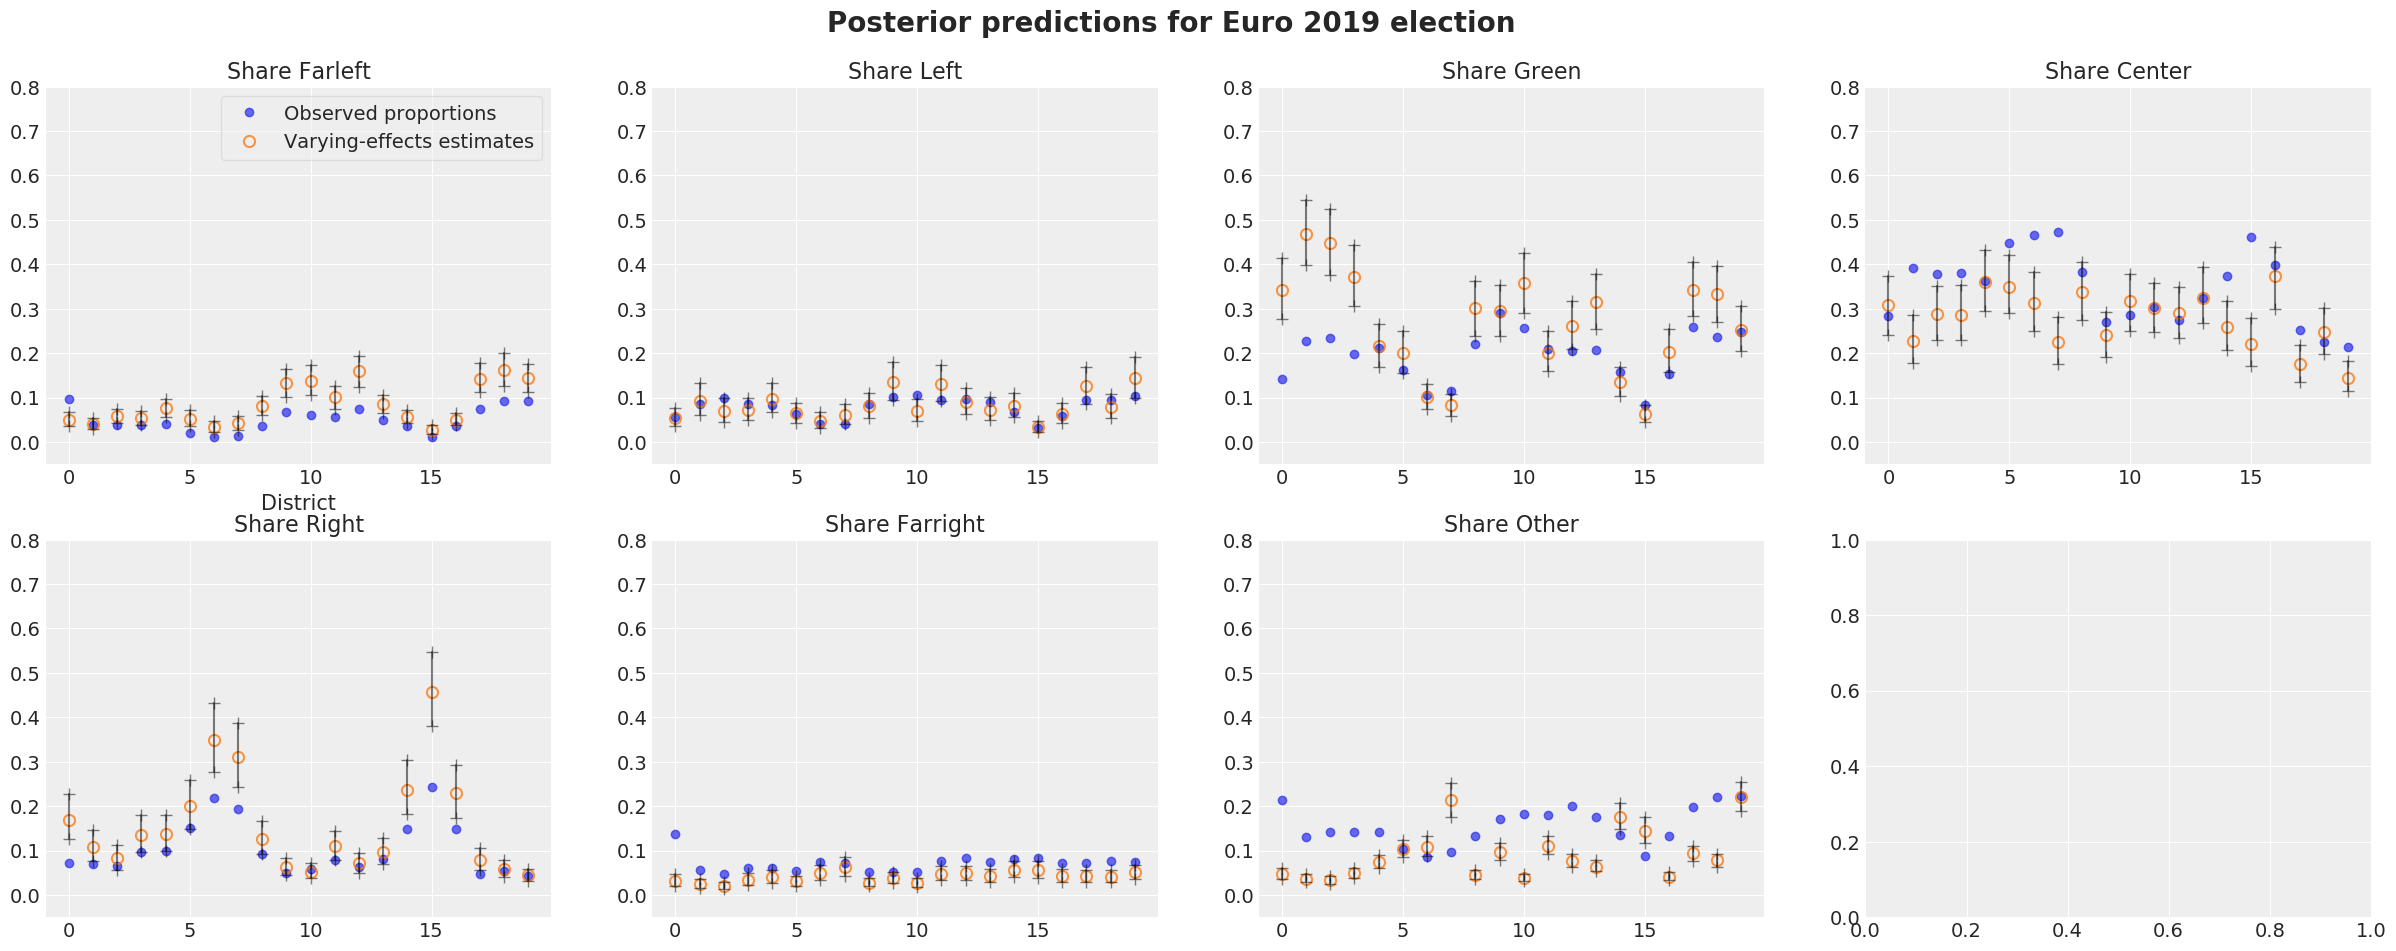

In [16]:
fig, axes = plt.subplots(2, 4, figsize=(30, 11))
for i, ax in enumerate(axes.flat):
    try:
        ax.plot(
            np.arange(Ndistricts),
            euro2019[PARTIES[i]] / euro2019["N"],
            "o",
            ms=6,
            alpha=0.7,
            label="Observed proportions",
        )
        ax.plot(
            np.arange(Ndistricts),
            share_mean[:, i],
            "o",
            fillstyle="none",
            ms=8,
            markeredgewidth=1.5,
            alpha=0.8,
            label="Varying-effects estimates",
        )
        ax.plot(
            [np.arange(Ndistricts), np.arange(Ndistricts)],
            az.hpd(share_est[:, :, i].T, credible_interval=0.99).T,
            "k-+",
            ms=8,
            alpha=0.5,
        )
        ax.set_xticks(range(Ndistricts), range(1, Ndistricts + 1))
        ax.set_title(f"Share {PARTIES[i].title()}")
        ax.set_ylim([-0.05, 0.8])
        if i == 0:
            ax.set_xlabel("District")
            ax.legend(frameon=True, framealpha=0.5)
    except IndexError:
        continue
fig.suptitle(
    "Posterior predictions for Euro 2019 election", y=0.95, size=20, weight="bold",
);